The following code demonstrates the [StandardImportToolPlugin](https://github.com/cat-cfs/StandardImportToolPlugin).  The simulation definition is built using the SITConfig helper class, and then imported via the Operational-Scale CBM-CFS3 standard import tool.  

The simulation is a replica of the CBM3 Tutorial1 afforestation project.  This tutorial can be found in your toolbox installation directory which is by default at this directory:

`C:\Program Files (x86)\Operational-Scale CBM-CFS3\Tutorials\Tutorial 1`


In [1]:
import sys, os, json, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

The following imports are used to load:
 1. The standard import tool plugin, which acts as an interface between python and your installed copy of the Operational-Scale CBM-CFS3 toolbox
 2. The cbm3_python package, which helps with automation of CBM3 simulation, CBM3 data management and and results analysis.

In [2]:
import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()
import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import cbm3_results

The next lines build a configuration for importing a CBM3 project using python code.  The paths to the project database, the results database and the initial project specification are set here.

Note the variables `c`, `project_path`, `results_db_path`, `config_save_path` which are re-used for later steps

In [3]:
project_path = r".\tutorial1\tutorial1.mdb"
results_db_path = r".\tutorial1\tutorial1_results.mdb"
config_save_path =  r".\tutorial1\config.json"

c = sit_helper.SITConfig(
    imported_project_path=project_path,
    initialize_mapping=True
)
c.data_config(
    age_class_size=5,
    num_age_classes=14,
    classifiers=["Stand ID", "Leading Species", "Land Cover"])

c.set_single_spatial_unit(17)
c.set_species_classifier("Leading Species")
c.map_species("Nonforest", "Not stocked")


The CBM3 inventory is specified on the next lines.  Like the CBM3 Tutorial1, 3x 10 hectare Stands are specified each with a non-forest initial condition. Three different soil types are specified.

In [4]:
c.add_inventory(classifier_set=["Stand 1", "Luvisolic (E. Canada)", "Nonforest"],
                area=10, age=0, unfccc_land_class=1)
c.add_inventory(classifier_set=["Stand 2", "Brunisolic", "Nonforest"],
                area=10, age=0, unfccc_land_class=1)
c.add_inventory(classifier_set=["Stand 3", "Average", "Nonforest"],
                area=10, age=0, unfccc_land_class=1)

On the next lines 3 disturbance events are specified.  Each event is set up to target all 3 of the defined areas.  The events are:
 1. An afforestation event on timestep 1: this will trigger a conversion from a non-forest stand to a forested stand.
 2. A clear cut on timestep 100 
 3. A Wild fire on timestep 150

In [5]:
c.add_event(classifier_set=["?","?","?"], disturbance_type="Afforestation", 
              time_step=1, target=30, target_type="Area", sort="SORT_BY_SW_AGE")

c.add_event(classifier_set=["?","?","?"], disturbance_type="Clear-cut with slash-burn",
              time_step=100, target=30, target_type="Area", sort="SORT_BY_SW_AGE")

c.add_event(classifier_set=["?","?","?"], disturbance_type="Wildfire", 
              time_step=150, target=30, target_type="Area", sort="SORT_BY_SW_AGE")


The next line defines a transition rule.  This transition rule prescribes that any stand affected by an afforestation event will be converted to a Red pine growth curve.

In [6]:
c.add_transition_rule(
    classifier_set_source=["?","?","?"],
    classifier_set_target=["?","Red pine","Forest Only"],
    disturbance_type="Afforestation", percent=100)

The growth curves are specified in the next block.  Two growth curves are defined and plotted:
 1. The Red Pine growth curve as defined in tutorial 1
 2. A not-stocked growth curve, this is necessary since CBM requires a growth curve for the initially non-forested stands

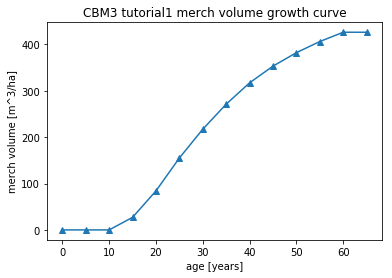

In [7]:
growth_curve_data = [0,0,0,27,84,155,217,271,317,353,382,406,426,426]

not_stocked_growth = [0.0]*len(growth_curve_data)

c.add_yield(classifier_set=["?","?","Nonforest"],
            leading_species_classifier_value="Not stocked",
            values=not_stocked_growth)

c.add_yield(classifier_set=["?","Red pine","Forest Only"], 
            leading_species_classifier_value="Red pine", values=growth_curve_data)

plt.plot(range(0,len(growth_curve_data)*5,5), growth_curve_data, marker='^')
plt.title("CBM3 tutorial1 merch volume growth curve")
plt.ylabel("merch volume [m^3/ha]")
plt.xlabel("age [years]")
plt.show()


The configuration which is attached to the variable `c` is used to import the project throught the Operational-Scale CBM-CFS3 standard import tool.  After the line finishes, a CBM-CFS3 project is created at the specified `project_path`.

In [8]:
c.import_project(standard_import_tool_plugin_path, config_save_path)

In the next block the Operational-Scale CBM-CFS3 is used to simulate the project.  The `project_path` and `results_db_path` defined on an earlier block are re-used. 

In [9]:
toolbox_path = r'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
results_db_path = cbm3_python.simulation.projectsimulator.run(
    aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
    project_path=os.path.abspath(project_path), 
    toolbox_installation_dir=toolbox_path,
    cbm_exe_path=os.path.join(toolbox_path, "admin", "executables"),
    results_database_path= results_db_path,
    afforestation_only=True)

The next blocks plot simulation results found in Tutorial1.  This Using the [cbm3_python](https://github.com/cat-cfs/cbm3_python/)  a few of the same plots found in Tutorial1 

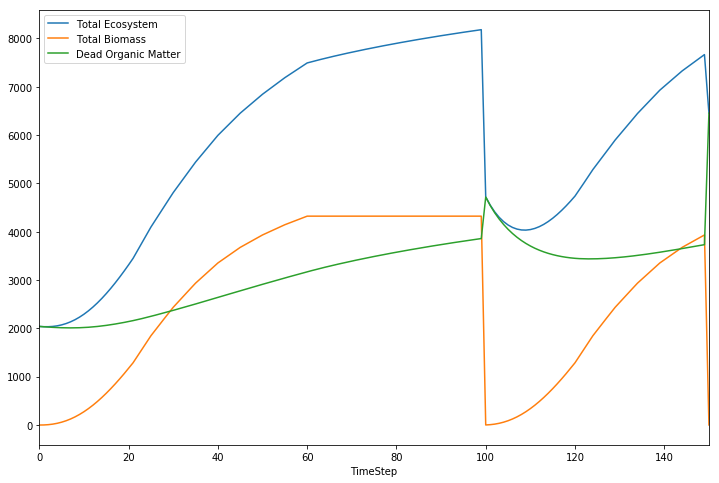

In [10]:
cols = ["TimeStep", "Total Ecosystem","Total Biomass", "Dead Organic Matter"]
df = cbm3_results.load_pool_indicators(results_db_path)[cols].groupby("TimeStep").sum()
df.plot(figsize=(12,8))

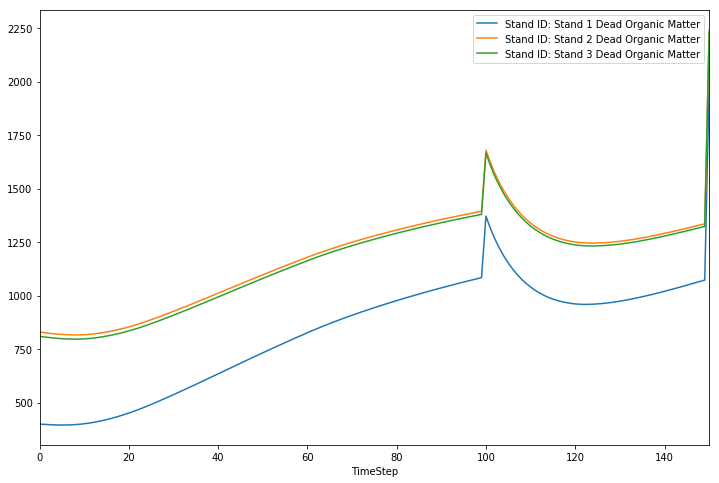

In [12]:
cols = ["TimeStep", "Dead Organic Matter", "Stand ID"]
df = cbm3_results.load_pool_indicators(results_db_path, classifier_set_grouping=True)[cols]

dfpivot = cbm3_results.pivot(df, "TimeStep", "Stand ID")
dfpivot.plot(figsize=(12,8))